# Data scraping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json

subdir1 = "CS4248 Project/ntuconfessions_data.json"
subdir2 = "CS4248 Project/ntu.json"

def load_file(subdir):
    path = f'/content/drive/MyDrive/{subdir}'
    data = json.load(open(f'{path}', 'rb'))
    return data
    
data1 = load_file(subdir1)
data2 = load_file(subdir2)


In [ ]:
import pandas as pd

def process_data(data):
    posts = data[0]["posts"]
    visited_urls = set()
    post_contents = []
    post_comments = []
    for post in posts:
        if post["postUrl"] in visited_urls:
            continue
            
        visited_urls.add(post["postUrl"])
        post_text = post["postText"]
        # remove hyperlink at end of post
        # truncated_text = post_text[:-53] # for nus
        truncated_text = post_text[:-47] # for ntu
        # truncated_text = post_text
        post_contents.append(truncated_text)

        for comment in post["postComments"]["comments"]:
            comment_text = comment["text"]
            post_comments.append(comment_text)
    return post_contents, post_comments

x1, x2 = process_data(data1)
x3, x4 = process_data(data2)
print(len(x3), len(x4))

652 3039


In [ ]:
post_contents = x1 + x2
post_comments = x3 + x4
print(len(post_contents), len(post_comments))

df1 = pd.DataFrame (post_contents,columns=['post_contents'])
df2 = pd.DataFrame (post_comments,columns=['post_comments'])

df1.to_csv(r'ntu_posts.csv', index = False, header=True)
df2.to_csv(r'ntu_comments.csv', index = False, header=True)

482 3691


# Load pretrained word embedding

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pickle
import json

# Define your own subdirectory 
subdir = "CS4248 Project/Data/"
path = f'/content/drive/MyDrive/{subdir}'

twitter_embedding_name = "embeddings_dict.pkl"
wikipedia_embedding_name = "embeddings_dict_wikipedia_100d.pkl"
finetune_embedding_name = "sms_glove.pkl"
finetune_embedding_name_ntu = "ntu_comment_glove.pkl"


twitter_embeddings_dict = pickle.load(open(f'{path}{twitter_embedding_name}', 'rb'))
# wikipedia_embeddings_dict = pickle.load(open(f'{path}{wikipedia_embedding_name}', 'rb'))

# update embedding
# combined_embeddings_dict = {}
new_embeddings_dict = pickle.load(open(f'{path}{finetune_embedding_name}', 'rb'))
new_embeddings_dict.update(twitter_embeddings_dict)

new_embeddings_dict_2 = pickle.load(open(f'{path}{finetune_embedding_name_ntu}', 'rb'))
new_embeddings_dict_2.update(twitter_embeddings_dict)


# Define LSTM

In [6]:
import torch.nn as nn
import torch
import textwrap

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

def get_weights(target_vocab, embeddings_dict, embedding_dim=100):
    matrix_len = len(target_vocab)
    weights_matrix = np.zeros((matrix_len, embedding_dim))
    words_found = 0
    oov_words = []

    for i, word in enumerate(target_vocab):
        try: 
            # print(embeddings_dict[word].shape)
            weights_matrix[i] = embeddings_dict[word]
            words_found += 1
        except KeyError:
            # oov_words.append(word)
            weights_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim, ))
        except:
            pass  

    return torch.tensor(weights_matrix)

def create_emb_layer(weights_matrix, trainable=False):
    num_embeddings, embedding_dim = weights_matrix.shape
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({'weight': weights_matrix})
    # set trainable for weights
    emb_layer.weight.requires_grad = trainable
      
    return emb_layer, num_embeddings, embedding_dim  

class SentimentNet(nn.Module):
    def __init__(self, target_vocab, embeddings_dict, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super(SentimentNet, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        # Learn new word embedding
        # vocab_size = len(target_vocab)
        # self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # Use pretrained word embedding
        weights_matrix = get_weights(target_vocab, embeddings_dict, embedding_dim)
        self.embedding, num_embeddings, embedding_dim = create_emb_layer(weights_matrix, trainable=True)
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc1 = nn.Linear(hidden_dim, 128)
        self.fc2 = nn.Linear(128, output_size)
        self.ReLU = nn.ReLU()
        self.LeakyReLU = nn.LeakyReLU(negative_slope=0.01)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, hidden):
        self.lstm.flatten_parameters() 
        batch_size = x.size(0)
        x = x.long()
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        # out = self.dropout(lstm_out)
        out = self.fc1(lstm_out)
        out = self.ReLU(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        
        out = out.view(batch_size, -1)
        out = out[:,-1]
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

# Choice 1: Preprocessing using only training set vocab as embedding layer

In [3]:
# Pad/truncate sentence to fixed length
# https://arxiv.org/abs/1903.07288 pad zeros in front
def pad_input(sentences, seq_len=100):
    features = np.zeros((len(sentences), seq_len), dtype=int)
    for i, tokens in enumerate(sentences):
        if len(tokens) > seq_len:
            features[i] = np.array(tokens)[:seq_len]
        elif len(tokens) > 0:
            features[i, -len(tokens):] = np.array(tokens)
    return features

def preprocess_input(X, y, seq_len=100, X_test_local=[], y_test_local=[], embeddings=None, replace_oov=False):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)
    X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, test_size=0.5, random_state=0)

    
    if len(X_test_local) > 0:
        X_test, X_val, y_test, y_val = train_test_split(X_test_local, y_test_local, test_size=0.5, random_state=0)
        # X_test = X_test_local
        # y_test = y_test_local

    # print(len(X_test))
    words = Counter() 
    count = 0
    for i, sentence in enumerate(X_train):
        # The sentences will be stored as a list of words/tokens
        X_train[i] = []
        for word in nltk.word_tokenize(sentence):  
            processed_word = word.lower()
            words.update([processed_word]) 
            X_train[i].append(processed_word)
    
    words = {k:v for k,v in words.items() if v > 1}
    words = sorted(words, key=words.get, reverse=True)
    # Adding padding and unknown to our vocabulary so that they will be assigned an index
    words = ['_PAD', '_UNKNOWN'] + words

    # Dictionaries to store the word to index mappings and vice versa
    word2idx = {o:i for i,o in enumerate(words)}
    idx2word = {i:o for i,o in enumerate(words)}

    for i, sentence in enumerate(X_train):
        X_train[i] = [word2idx[word] if word in word2idx else 1 for word in sentence]

    for i, sentence in enumerate(X_val):
        X_val[i] = [word2idx[word.lower()] if word.lower() in word2idx else 1 for word in nltk.word_tokenize(sentence)]

    oov = set()
    for i, sentence in enumerate(X_test):
        X_test[i] = [word2idx[word.lower()] if word.lower() in word2idx else 1 for word in nltk.word_tokenize(sentence)]
        
        for word in nltk.word_tokenize(sentence):
            if word.lower() not in word2idx:
                oov.add(word)
    oov = list(oov)

    print("----------------Training input statistics----------------")
    print("Preview of first 50 OOV words in test data: ", oov[:50])
    print("Total number of OOV words in test data: ", len(oov))
    print("Max tokens in training data: ", np.max([len(x) for x in X_train]))
    # print("Min tokens: ", np.min([len(x) for x in X_train]))
    print("Average tokens: ", np.mean([len(x) for x in X_train]))
    print("----------------------------------------------------------")

    train_sentences = pad_input(X_train, seq_len)
    val_sentences = pad_input(X_val, seq_len)
    test_sentences = pad_input(X_test, seq_len)

    return train_sentences, val_sentences, test_sentences, y_train, y_val, y_test, words, idx2word

# Choice 2: Preprocessing using entire embedding vocab as embedding layer

In [13]:
# Pad/truncate sentence to fixed length
# https://arxiv.org/abs/1903.07288 pad zeros in front
def pad_input(sentences, seq_len=100):
    features = np.zeros((len(sentences), seq_len), dtype=int)
    for i, tokens in enumerate(sentences):
        if len(tokens) >= seq_len:
            features[i] = np.array(tokens)[:seq_len]
        elif len(tokens) > 0:
            features[i, -len(tokens):] = np.array(tokens)
    return features

from nltk.metrics import edit_distance
import re
def get_closest_word(word, dictionary):
    min = np.inf
    closest = "_UNKNOWN"
    word = re.sub(r'[^\w\s]', '', word)
    print(word)
    for s in dictionary:
        if s == word:
            return s

        if abs(len(s) - len(word)) > 2:
            continue
        dist = edit_distance(word, s)
        # optimizations
        if dist < 3:
            return s

        if dist < min:
            closest = s
            min = dist
    return closest

def preprocess_input(X, y, seq_len=100, X_test_local=[], y_test_local=[], embeddings=None, replace_oov=False):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)
    X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, test_size=0.5, random_state=0)

    
    if len(X_test_local) > 0:
        X_test, X_val, y_test, y_val = train_test_split(X_test_local, y_test_local, test_size=0.5, random_state=0)
        # X_test = X_test_local
        # y_test = y_test_local

    # print(len(X_test))
    words = list(embeddings.keys())
    print("Embedding size: ", len(words))
    
    # words = {k:v for k,v in words.items() if v > 1}
    # words = sorted(words, key=words.get, reverse=True)
    # Adding padding and unknown to our vocabulary so that they will be assigned an index
    words = ['_PAD', '_UNKNOWN'] + words

    # Dictionaries to store the word to index mappings and vice versa
    word2idx = {o:i for i,o in enumerate(words)}
    idx2word = {i:o for i,o in enumerate(words)}

    for i, sentence in enumerate(X_train):
        X_train[i] = [word2idx[word.lower()] if word.lower() in word2idx else 1 for word in nltk.word_tokenize(sentence)]

    oov = set()
    word2closestword = {}
    for i, sentence in enumerate(np.concatenate((X_val, X_test))):
        # X_test[i] = [word2idx[word.lower()] if word.lower() in word2idx else 1 for word in nltk.word_tokenize(sentence)]
        for word in nltk.word_tokenize(sentence):
            w = word.lower()
            if w not in word2idx and w not in word2closestword.keys():
                oov.add(w)
                if replace_oov:
                    word2closestword[w] = get_closest_word(w, words)
                # print("Processed OOV: ", len(list(oov)))

    for i, sentence in enumerate(X_val):
        if replace_oov:
            X_val[i] = [word2idx[word.lower()] if word.lower() in word2idx else word2idx[word2closestword[word.lower()]]\
                      for word in nltk.word_tokenize(sentence)]
        else:
            X_val[i] = [word2idx[word.lower()] if word.lower() in word2idx else 1 for word in nltk.word_tokenize(sentence)]

    for i, sentence in enumerate(X_test):
        if replace_oov:
            X_test[i] = [word2idx[word.lower()] if word.lower() in word2idx else word2idx[word2closestword[word.lower()]]\
                      for word in nltk.word_tokenize(sentence)]
        else:
            X_test[i] = [word2idx[word.lower()] if word.lower() in word2idx else 1 for word in nltk.word_tokenize(sentence)]

    oov = list(oov)
    print("----------------Training input statistics----------------")
    print("Substituted words: ", word2closestword)
    print("Preview of first 50 OOV words in test data: ", oov[:50])
    print("Total number of OOV words in test data: ", len(oov))
    print("Max tokens in training data: ", np.max([len(x) for x in X_train]))
    # print("Min tokens: ", np.min([len(x) for x in X_train]))
    print("Average tokens: ", np.mean([len(x) for x in X_train]))
    print("----------------------------------------------------------")

    train_sentences = pad_input(X_train, seq_len)
    val_sentences = pad_input(X_val, seq_len)
    test_sentences = pad_input(X_test, seq_len)

    return train_sentences, val_sentences, test_sentences, y_train, y_val, y_test, words, idx2word
    


In [ ]:
import pandas as pd
import numpy as np
import copy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from scipy.sparse import csr_matrix
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.feature_extraction.text import TfidfVectorizer

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

import math
from collections import Counter
import nltk
nltk.download('punkt')
from nltk import word_tokenize  

url = "https://raw.githubusercontent.com/calvincxz/CS4248_Project/main/train2.csv"
train = pd.read_csv(url)
X = np.array(train['comment_text'])
y = np.array(train['toxic_label'])

# reduce size for faster training
size = X.shape[0]
# size = 40000

X = X[:size]
y = y[:size]
X_test_local = []
y_test_local = []

url = "https://raw.githubusercontent.com/calvincxz/CS4248_Project/main/local_data_301.csv"
test_local = pd.read_csv(url)
X_test_local = np.array(test_local['Comment'])
y_test_local = np.array(test_local['Insult'])

train_sentences, val_sentences, test_sentences, y_train, y_val, y_test, vocab, idx2word \
= preprocess_input(X, y, seq_len=200, X_test_local=X_test_local, y_test_local=y_test_local)


# train_and_evaluate_model(embeddings_dict=wikipedia_embeddings_dict, X_test_local=X_test_local, y_test_local=y_test_local)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Embedding size:  1193514
----------------Training input statistics----------------
Preview of first 50 OOV words in test data:  ['Groovelife', '...', 'deglove', 'ahmah', 'kwailan', 'limpeh', 'sinkie', 'la..china', "y'all", 'uplorry', '...', '...', 'Covidiots', 'dormitories', '100/day', '600', 'leg..', '80', '20', '20', 'dormitories', 'dormitories', 'expenses…', 'Pappies', 'PG/MG', 'peepur', 'COVID-19', '...', 'northing', '...', 'extramiles', '..', '...', 'pedestral', '1', 'laosai', 'Kbkb', 'covid', 'satki', 'rubbish.Everywhere', 'Covid', 'mah..', 'Sporeans', 'satki', '2k', '5', 'ourselves..', 'again..', 'sh*t', 'sinkie']
Total number of OOV words in test data:  109
Max tokens in training data:  4948
Average tokens:  75.06390318054257
----------------------------------------------------------


# Data Visualization

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


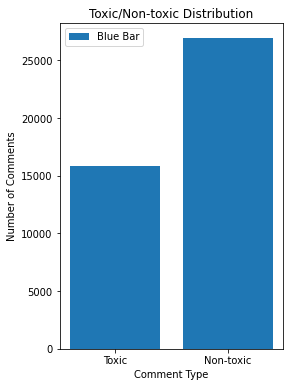

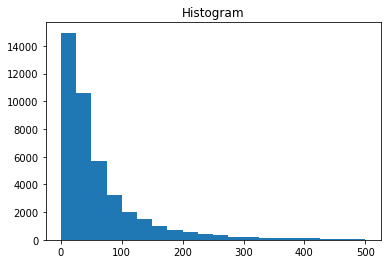

In [ ]:
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
from nltk import word_tokenize  
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/calvincxz/CS4248_Project/main/train2.csv"
train = pd.read_csv(url)
X = np.array(train['comment_text'])
y = np.array(train['toxic_label'])

for i, sentence in enumerate(X):
    X[i] = []
    for word in nltk.word_tokenize(sentence): 
        X[i].append(word)

x1 = ["Toxic", "Non-toxic"]
y1 = [sum(y), len(y)-sum(y)]

fig = plt.figure(figsize =(4,6))
plt.bar(x1, y1, label="Blue Bar", )
plt.plot()

plt.xlabel("Comment Type")
plt.ylabel("Number of Comments")
plt.title("Toxic/Non-toxic Distribution")
plt.legend()
plt.show()

n = [len(x) for x in X]
m = [m for m in range(len(n))]

plt.hist(n, bins=20, range=(0, 500))
plt.title("Histogram")
plt.show()

# Main

In [11]:
import pandas as pd
import numpy as np
import copy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from scipy.sparse import csr_matrix
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.feature_extraction.text import TfidfVectorizer

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

import math
from collections import Counter
import nltk
nltk.download('punkt')
from nltk import word_tokenize  


def train_and_evaluate_model(embeddings_dict, X_test_local=[], y_test_local=[], local=False, replace_oov=False):
    url = "https://raw.githubusercontent.com/calvincxz/CS4248_Project/main/train2.csv"
    train = pd.read_csv(url)
    X = np.array(train['comment_text'])
    y = np.array(train['toxic_label'])
    # X_test_local = []
    # y_test_local = []
    batch_size = 64

    if local:
        url = "https://raw.githubusercontent.com/calvincxz/CS4248_Project/main/local_data_301.csv"
        test_local = pd.read_csv(url)
        X_test_local = np.array(test_local['Comment'])
        y_test_local = np.array(test_local['Insult'])
        batch_size = 16

    # reduce size for faster training
    size = X.shape[0]
    # size = 10000

    X = X[:size]
    y = y[:size]

    train_sentences, val_sentences, test_sentences, y_train, y_val, y_test, vocab, idx2word \
    = preprocess_input(X, y, seq_len=200, X_test_local=X_test_local, y_test_local=y_test_local, \
                       embeddings=embeddings_dict, replace_oov=replace_oov)

    train_data = TensorDataset(torch.from_numpy(train_sentences), torch.from_numpy(y_train))
    val_data = TensorDataset(torch.from_numpy(val_sentences), torch.from_numpy(y_val))
    test_data = TensorDataset(torch.from_numpy(test_sentences), torch.from_numpy(y_test))

    
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
    val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size, drop_last=True)
    test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True)

    output_size = 1
    embedding_dim = len(list(embeddings_dict.values())[0])
    vocab_size = len(vocab)

    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    # print(device)

    model = SentimentNet(vocab, embeddings_dict, output_size, embedding_dim, hidden_dim=128, n_layers=2, drop_prob=0.2)
    model.to(device)

    lr=0.0003
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True)

    epochs = 5
    counter = 0
    print_every = int(0.5 * len(y_train) / batch_size)
    clip = 5
    valid_loss_min = np.Inf
    best_model_so_far = None

    # Set seed
    torch.manual_seed(1)
    np.random.seed(0)
    model.train()
    for i in range(epochs):
        h = model.init_hidden(batch_size)
        
        for inputs, labels in train_loader:
            counter += 1
            h = tuple([e.data for e in h])
            inputs, labels = inputs.to(device), labels.to(device)
            model.zero_grad()
            output, h = model(inputs, h)
            loss = criterion(output.squeeze(), labels.float())
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
            # lr_scheduler.step()
            
            if counter % print_every == 0:
                val_h = model.init_hidden(batch_size)
                val_losses = []
                model.eval()
                for val_input, val_label in val_loader:
                    val_h = tuple([each.data for each in val_h])
                    val_input, val_label = val_input.to(device), val_label.to(device)
                    out, val_h = model(val_input, val_h)
                    val_loss = criterion(out.squeeze(), val_label.float())
                    val_losses.append(val_loss.item())
                    
                model.train()
                print("Epoch: {}/{}...".format(i+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.6f}...".format(loss.item()),
                      "Val Loss: {:.6f}".format(np.mean(val_losses)))
                if np.mean(val_losses) <= valid_loss_min:
                    # torch.save(model.state_dict(), './state_dict.pt')
                    best_model_so_far = copy.deepcopy(model)
                    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
                    valid_loss_min = np.mean(val_losses)

    test_losses = []
    h = model.init_hidden(batch_size)
    test_inputs = np.array([])
    outputs = np.array([])
    test_labels = np.array([])

    # load the best model which was saved previously
    model =  best_model_so_far

    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            h = tuple([each.data for each in h])
            inputs, labels = inputs.to(device), labels.to(device)
            output, h = model(inputs, h)
            test_loss = criterion(output.squeeze(), labels.float())
            test_losses.append(test_loss.item())
            pred = torch.round(output.squeeze())

            if len(test_inputs) == 0:
                test_inputs = inputs.cpu().numpy()
            else:
                test_inputs = np.concatenate([test_inputs, inputs.cpu().numpy()])
            outputs = np.concatenate([outputs, pred.cpu().numpy()])
            test_labels = np.concatenate([test_labels, labels.cpu().numpy()])
        
        f1score = f1_score(np.array(test_labels), outputs)
        recall = recall_score(np.array(test_labels), outputs)
        precision = precision_score(np.array(test_labels), outputs)
        accuracy = accuracy_score(np.array(test_labels), outputs)
        print("##############################################################")
        print("Test Statistics:")
        print(f"Test F1 score: {f1score}")
        print(f"Test recall: {recall}")
        print(f"Test precision: {precision}")
        print(f"Test accuracy: {accuracy}")
        print("##############################################################")
        # Print some wrong predictions
        for i, input in enumerate(test_inputs[:100]):
            if outputs[i] != test_labels[i]:
              input_no_pad = input[input != 0]
              print(f"Label: {test_labels[i]}, Prediction: {outputs[i]}")
              print(" ".join([idx2word[i] for i in input_no_pad]))
              print()
        return f1score, recall, precision, accuracy
# if __name__ == "__main__":
#     main()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Evaluate Model

In [12]:
train_and_evaluate_model(embeddings_dict=twitter_embeddings_dict, local=False, replace_oov=False)

----------------Training input statistics----------------
Preview of first 50 OOV words in test data:  ['termnot', 'один', 'Mallow', 'central-Europe', 'copy-right', 'left-facing', 'soforth', 'Canaan', 'Timmy', 'intuitive.LexVacPac3', 'slagging', 'DD214', 's=143', 'Endoscope5', 'emulsions', '6ft', 'nouvelle', 'bikini', 'Ivanov', 'pedophilic', 'rebus', 'Pershing', 'alledy', 'Hypocracy', 'appended', '//www.questia.com/library/encyclopedia/columbus_christopher.jsp', 'NON-FACT', 'Linden', 'Grazie', 'terwible', 'grandpa', 'Sedunary', 'well-supported', 'Felician', 'contras', 'Lithuanians', 'bull-shit', 'LOVCKED', 'pluralized', '℥·start', 'GEniusboyIII', '==An', 'image-forging', '//www.parliament.nsw.gov.au/prod/lc/lctabdoc.nsf/cccc870c6126b1b6ca2571ee000318a4/6e2b81f5c474172fca257cee0023c16a', 'Clemmensen', 'Dunes.jpg', '86.178.140.114', 'Account==', 'checker', '978-966-671-179-6']
Total number of OOV words in test data:  9537
Max tokens in training data:  4948
Average tokens:  75.06390318054

(0.9048665620094192,
 0.9149206349206349,
 0.8950310559006212,
 0.9282670454545454)

# Evaluate Model on Local Data (Using training set vocab)

In [9]:
url = "https://raw.githubusercontent.com/calvincxz/CS4248_Project/main/local_data_301.csv"
test_local = pd.read_csv(url)
X_test_local = np.array(test_local['Comment'])
y_test_local = np.array(test_local['Insult'])
# train_and_evaluate_model(embeddings_dict=twitter_embeddings_dict, X_test_local=X_test_local, y_test_local=y_test_local)
train_and_evaluate_model(embeddings_dict=twitter_embeddings_dict, local=True, replace_oov=False)


----------------Training input statistics----------------
Preview of first 50 OOV words in test data:  ['hag', 'tiong', 'hardworking', 'suay', 'uncooperative', 'fw', 'accomodation', 'pisai', 'Aiyo', 'uplorry', 'Singaporean', 'xia', 'mah..', '🇸🇬', 'CECA', 'knn', 'soups', 'Diam', 'attractive/can', 'sda', 'woof', 'liao', 'hardship', 'edmwers', 'shouldn', 'laosai', 'sinkie', 'unwashed', 'slipper', 'wuhan', 'smokers', 'pariah', 'satki', 'hantu', 'lim', "'strawberry", '9gag', 'leeways', 'DIU~~~~', 'tummy', 'hotspots', '100/day', 'buay', "'snowflakes", 'Groovelife', 'bodyguards', 'cb', 'COVID19', 'Frontline', '10million']
Total number of OOV words in test data:  168
Max tokens in training data:  4948
Average tokens:  75.06390318054257
----------------------------------------------------------
Epoch: 1/5... Step: 1069... Loss: 0.319521... Val Loss: 0.672348
Validation loss decreased (inf --> 0.672348).  Saving model ...
Epoch: 1/5... Step: 2138... Loss: 0.166250... Val Loss: 0.585584
Validatio

(0.618705035971223, 0.5972222222222222, 0.6417910447761194, 0.6319444444444444)

# Evaluate Model on Local Data (Using Entire Embedding Vocab)

In [14]:
url = "https://raw.githubusercontent.com/calvincxz/CS4248_Project/main/local_data_301.csv"
test_local = pd.read_csv(url)
X_test_local = np.array(test_local['Comment'])
y_test_local = np.array(test_local['Insult'])
# train_and_evaluate_model(embeddings_dict=twitter_embeddings_dict, X_test_local=X_test_local, y_test_local=y_test_local)
train_and_evaluate_model(embeddings_dict=twitter_embeddings_dict, local=True, replace_oov=False)


Embedding size:  1193514
----------------Training input statistics----------------
Substituted words:  {}
Preview of first 50 OOV words in test data:  ['worse..', '3rd', 'sporeans', 'actually..', 'pg/mg', '1', 'brain.that', 'pisai', 'any1', '10', 'life..', 'whor*', 'ptui', 'uplorry', '🇸🇬', 'mah..', 'attractive/can', 'dumbccb', 'stuppiak', 'covid19', 'edmwers', 'peepur', 'laosai', 'sinkie', 'kbkb', 'satki', 'kumgongness', '.only', "'strawberry", 'leeways', '9gag', 'amitabha', 'non-prohibited', '.no', "'fit", '..dun', '.birkin', '100/day', '928', 'rah.but', '20', 'donch', "'snowflakes", '11th', '2k', '19', '3', 'siaolang', '10million', 'teachers.we']
Total number of OOV words in test data:  131
Max tokens in training data:  4948
Average tokens:  75.06390318054257
----------------------------------------------------------
Epoch: 1/5... Step: 1069... Loss: 0.283302... Val Loss: 0.560283
Validation loss decreased (inf --> 0.560283).  Saving model ...
Epoch: 1/5... Step: 2138... Loss: 0.1871

(0.6338028169014085, 0.625, 0.6428571428571429, 0.6388888888888888)

# Evaluate Model on twitter + ntu embeddings (with OOV replacement using edit distance)

In [ ]:
# combined with NTU comments wit
train_and_evaluate_model(embeddings_dict=new_embeddings_dict_2, local=True, replace_oov=True)


Embedding size:  1195762
no
Processed OOV:  1
birkin
Processed OOV:  2
pisai
Processed OOV:  3
oppies
Processed OOV:  4
jjww
Processed OOV:  5
amitabha
Processed OOV:  6
epithets
Processed OOV:  7
300500
Processed OOV:  8
rahbut
Processed OOV:  9
942
Processed OOV:  10
928
Processed OOV:  11
whor
Processed OOV:  12
154th
Processed OOV:  13
sure
Processed OOV:  14
gahment
Processed OOV:  15
siaolang
Processed OOV:  16
dumbccb
Processed OOV:  17
ashle
Processed OOV:  18
blardy
Processed OOV:  19
it
Processed OOV:  20
stuppiak
Processed OOV:  21
fumigation
Processed OOV:  22
braiiiinnnnnnn
Processed OOV:  23
americanised
Processed OOV:  24
teacherswe
Processed OOV:  25
sinkies
Processed OOV:  26
life
Processed OOV:  27
worse
Processed OOV:  28
donch
Processed OOV:  29
nonprohibited
Processed OOV:  30
mrstinkie95
Processed OOV:  31
11th
Processed OOV:  32
ing
Processed OOV:  33
kumgongness
Processed OOV:  34
tiongs
Processed OOV:  35
property
Processed OOV:  36
actually
Processed OOV:  37


(0.5045045045045045, 0.4, 0.6829268292682927, 0.6180555555555556)

In [ ]:
train_and_evaluate_model(embeddings_dict=new_embeddings_dict, local=True)

Embedding size:  1209600
----------------Training input statistics----------------
Preview of first 50 OOV words in test data:  ['10million', 'grabie', 'limpeh', 'unlucky..', 'edmwers', 'dormitories', 'la..china', 'Sporeans', 'uplorry', 'mask..', 'kwailan', 'northing', 'ourselves..', 'garhemen', "'snowflakes", 'COVID19', 'motherfcuker', 'grabbie..', 'covid', 'deglove', 'leeways', '100/day', 'Pappies', 'cut-paste', 'pedestral', 'China..', 'Limpeh', 'Covidiots', 'extramiles', 'pisai', 'satki', 'mah..', 'smoker…', 'Ptui', 'anti-chinese', 'leg..', 'enforcements', 'Groovelife', 'Kbkb', 'sh*t', 'COVID-19', 'Covid', 'PG/MG', 'sinkie', 'S/O', 'peepur', "'strawberry", 'attractive/can', 'again..', 'yayapapa']
Total number of OOV words in test data:  56
Max tokens in training data:  4948
Average tokens:  75.06390318054257
----------------------------------------------------------
Epoch: 1/5... Step: 1069... Loss: 0.337703... Val Loss: 0.582029
Validation loss decreased (inf --> 0.582029).  Saving

(0.6330935251798562,
 0.6111111111111112,
 0.6567164179104478,
 0.6458333333333334)

In [ ]:
from nltk.metrics import edit_distance

def get_closest_word(word, dictionary):
    min = np.inf
    closest = ""
    for s in dictionary:
        dist = edit_distance(word, s)
        if dist < min:
            closest = s
            min = dist
    return closest

4

# Train Logistic Regression

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from scipy.sparse import csr_matrix
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.feature_extraction.text import TfidfVectorizer

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

import math
from collections import Counter
import nltk
nltk.download('punkt')
from nltk import word_tokenize  


def main():
    url = "https://raw.githubusercontent.com/calvincxz/CS4248_Project/main/train2.csv"
    train = pd.read_csv(url)
    X = np.array(train['comment_text'])
    y = np.array(train['toxic_label'])

    size = X.shape[0]
    X = X[:size]
    y = y[:size]

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)
    X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, test_size=0.5, random_state=0)

    model = LogisticRegression(random_state=0, solver='sag', max_iter=200)
    vectorizer = TfidfVectorizer()
    X_train_tf_idf_matrix = vectorizer.fit_transform(X_train)
    model.fit( X_train_tf_idf_matrix, y_train)

    # test your model
    vectorizer_val = TfidfVectorizer(vocabulary=vectorizer.get_feature_names())
    # vectorizer_val = TfidfVectorizer(vocabulary=vocab)
    X_val_tf_idf_matrix = vectorizer_val.fit_transform(X_val)

    y_pred = model.predict(X_val_tf_idf_matrix)
    score = f1_score(y_val, y_pred, average='macro')
    acc = accuracy_score(y_val, y_pred)
    print('F1 score on validation = {}'.format(score))
    print('accuracy = {}'.format(acc))
 
if __name__ == "__main__":
    main()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
F1 score on validation = 0.8890783112960081
accuracy = 0.8999064546304958
